In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, precision_recall_fscore_support

# Command to convert .log.labeled files to .csv
# tr '\t' ',' < "(name).log.labeled" | cut -d ',' -f 1-22 > "(name).csv"

# Command to change directory
# cd /mnt/(path name)

# Replace first 7 lines of .csv file (until #types) with the header below
# timestamp,uid,src_ip,src_port,dest_ip,dest_port,protocol,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label

# Load the CSV files
benign = pd.read_csv(r"D:\AI Training\ML Model\CSV\Benign.csv")
torii = pd.read_csv(r"D:\AI Training\ML Model\CSV\Torii.csv")
mirai = pd.read_csv(r"D:\AI Training\ML Model\CSV\Mirai.csv")

# Add a label column for each dataset
benign['label'] = 0
torii['label'] = 1
mirai['label'] = 2

# Concatenate the datasets
data = pd.concat([benign, torii, mirai], axis=0)

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows
data.head()

,timestamp,uid,src_ip,src_port,dest_ip,dest_port,protocol,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545411e+09,C1HrOb3gEhOYfqHxR5,192.168.1.195,56431,192.168.1.1,53,udp,dns,5.005399,78,...,S0,-,-,0,D,2,134,0,0,2
1,1.537529e+09,CQykLqpNaqHYbT3P3,192.168.2.3,46786,176.32.98.203,80,tcp,http,0.235654,135,...,SF,-,-,0,ShADafF,4,315,4,406,0
2,1.545411e+09,CYsX5h49x4DAaoGmR9,192.168.1.195,38326,192.168.1.1,53,udp,dns,0.131422,39,...,SF,-,-,0,Dd,1,67,1,131,2
3,1.545467e+09,CJXFEL3HKK9x0KzXZ6,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,OTH,-,-,0,C,0,0,0,0,2
4,1.545415e+09,CazVLx1zrxkNjvrklj,192.168.1.195,52126,185.244.25.235,6667,tcp,irc,1.079634,75,...,S3,-,-,0,ShAdDaf,8,499,6,563,2


In [2]:
# Separate the features (X) and the target (y)
X = data.drop('label', axis=1)
y = data['label']

# Identify numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns

# Identify categorical columns that should be encoded
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Normalize only the numeric columns
scaler = StandardScaler()
X_scaled = X_encoded.copy()  # Make a copy of the encoded DataFrame
X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])

# Convert the labels to one-hot encoding
y_encoded = to_categorical(y, num_classes=3)  # 3 classes: Benign, Torii, Mirai

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [3]:
# Check class distribution before resampling
print("Original training set class distribution:")
print(pd.Series(np.argmax(y_train, axis=1)).value_counts())

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, np.argmax(y_train, axis=1))

# Check class distribution after resampling
print("Resampled training set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

# Convert back to one-hot encoding after resampling
y_train_resampled_encoded = to_categorical(y_train_resampled, num_classes=3)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

print("Class weights:", class_weight_dict)

Original training set class distribution:
2    18546
1     2524
0     1474
Name: count, dtype: int64
Resampled training set class distribution:
2    18546
0    18546
1    18546
Name: count, dtype: int64
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


In [4]:
# Define the model architecture
model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: Benign, Torii, Mirai
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Display model summary
model.summary()

c:\Users\ahren\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    18,418,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,582,787 (70.89 MB)

 Trainable params: 18,582,787 (70.89 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_resampled,
    y_train_resampled_encoded,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 261s 297ms/step - accuracy: 0.9257 - loss: 5.2267 - precision: 0.9981 - recall: 0.6467 - val_accuracy: 1.0000 - val_loss: 0.4451 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 248s 285ms/step - accuracy: 0.9998 - loss: 0.3062 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 1.0000 - val_loss: 0.1174 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 251s 289ms/step - accuracy: 0.9997 - loss: 0.1142 - precision: 0.9997 - recall: 0.9997 - val_accuracy: 1.0000 - val_loss: 0.0888 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 252s 290ms/step - accuracy: 0.9996 - loss: 0.0913 - precision: 0.9996 - recall: 0.9996 - val_accuracy: 1.0000 - val_loss: 0.0766 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 249s 286ms/step - accuracy: 0.9998 - loss: 0.0797 - precision: 0.9998 - recall: 0.9998 - val_accura

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       1.00      1.00      1.00       685
           2       1.00      1.00      1.00      4599

    accuracy                           1.00      5636
   macro avg       1.00      1.00      1.00      5636
weighted avg       1.00      1.00      1.00      5636



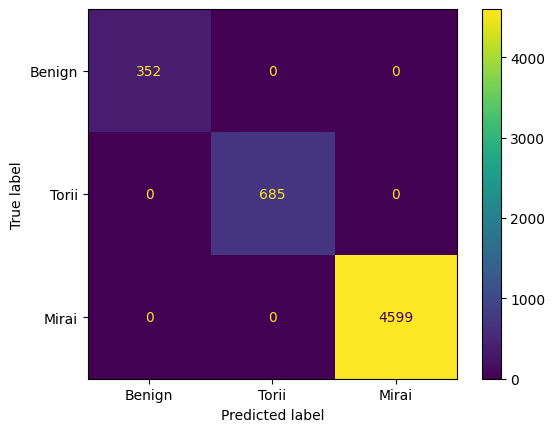

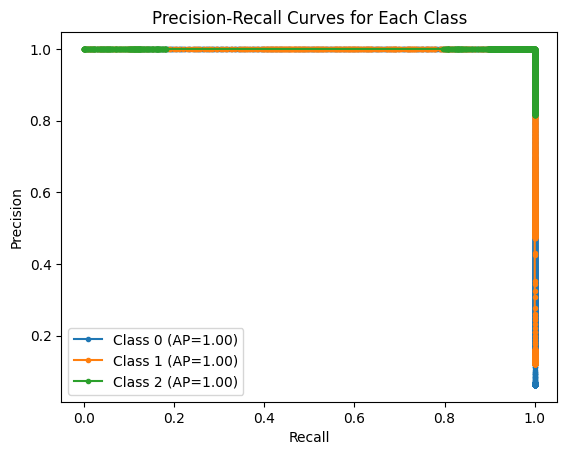

Average Precision for Class 0: 1.00
Average Precision for Class 1: 1.00
Average Precision for Class 2: 1.00


In [6]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report (Precision, Recall, F1-score)
print("Final Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Plot the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Torii', 'Mirai'])
disp.plot(cmap='viridis')
plt.show()

# Calculate precision-recall curves and average precision scores
precision = {}
recall = {}
average_precision = {}

for i in range(3):  # 3 classes: 0 (Benign), 1 (Torii), 2 (Mirai)
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])  # OvR for each class
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# Plot precision-recall curves for each class
for i in range(3):
    plt.plot(recall[i], precision[i], marker='.', label=f'Class {i} (AP={average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.show()

# Print average precision scores for each class
for i in range(3):
    print(f'Average Precision for Class {i}: {average_precision[i]:.2f}')